In [35]:
!pip install langdetect
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
import pandas as pd
import numpy as np
import nltk
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from nltk.stem.wordnet import WordNetLemmatizer
from langdetect import detect
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from pandas.api.types import CategoricalDtype

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import ast


from IPython.core.interactiveshell import InteractiveShell
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 1000)
InteractiveShell.ast_node_interactivity = "all"
sns.set_theme(font_scale=1.5, style="darkgrid")
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reviews

In [ ]:
### Read and concatenate all reviews
# List of all cities
city_list = {
    "LA": "Los Angeles",
    "OAK": "Oakland",
    "PGR": "Pacific Grove",
    "SD": "San Diego",
    "SF": "San Francisco",
    "SM": "San Mateo County",
    "SCC": "Santa Clara County",
    "SCZ": "Santa Cruz County"
} 
# Read the reviews data
file_name = '/content/drive/My Drive/BT4222 Data Mining/Code & Data/Reviews/{} Review.csv'

df_list = []
for abb, name in city_list.items():
    temp_df = pd.read_csv(file_name.format(name))
    temp_df['state'] = name # add a city column
    df_list.append(temp_df) 

df = pd.concat(df_list) # combine all df

In [ ]:
### Process data into usable format
df['comments'] = df['comments'].astype(str)
df = df.loc[df['comments'].str.contains(r'[^\x00-\x7F]+') == False] # Remove non-ASCII characters
df['comments'] = df['comments'].str.replace(r'<[^<>]*>', ' ', regex=True) # Replace html codes between brackets
df['comments'] = df['comments'].str.replace('[^\w\s]','') # ???
df['comments'] = df['comments'].str.replace('\\r','') # # Remove \\r in some rows
df['comments'] = df['comments'].str.replace('<br/>','') # Replace break line in comments
df = df[df['comments'].str.contains('[A-Za-z]')] # Keep only comments containing alphabets
# df[df['comments'].apply(lambda x: detect(x) == 'en')]

In [ ]:
def stopwords_removal(corpus):
    wh_words = ['who', 'what', 'when', 'why', 'how', 'which', 'where', 'whom']
    stop = set(stopwords.words('english'))
    for word in wh_words:
        stop.remove(word)
    corpus = [[x for x in str(x).split() if x not in stop] for x in corpus]
    return corpus

def lemmatize(corpus):
    lem = WordNetLemmatizer()
    corpus = [[lem.lemmatize(x) for x in x] for x in corpus]
    return corpus

def stem_sentences(sentence):
    tokens = sentence.split()
    porter_stemmer = PorterStemmer()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def process(corpus):
    corpus = corpus.str.lower()
    corpus = stopwords_removal(corpus)
    corpus = lemmatize(corpus)
    corpus = [' '.join(x) for x in corpus]
    return corpus

In [ ]:
sia = SentimentIntensityAnalyzer()
# Sample
text = "Wow, NLTK is really powerful!"
sia.polarity_scores(text) 
TextBlob(text).sentiment.subjectivity

In [ ]:
### Identify VADER or TextBlob
### Identify if preprocessing is helpful
toSample = [14606598,3590546,246110235,206866,173669972,534577160,102916633,180533648,194060830,84208077] 
# 5 Positive and 5 Negative Examples
sample = df[df['id'].isin(toSample)].copy()
sample['VADER_compound'] = [sia.polarity_scores(x)['compound'] for x in sample['comments']]
sample['textblob_polarity'] = sample['comments'].astype(str).map(lambda text: TextBlob(text).sentiment.polarity)
sample['processed_comments'] = process(sample['comments'])
sample['processed_comments'].apply(stem_sentences)
sample['VADER_processed'] = [sia.polarity_scores(x)['compound'] for x in sample['processed_comments']]
sample['textblob_processed'] = sample['processed_comments'].astype(str).map(lambda text: TextBlob(text).sentiment.polarity)

# Highlight number 102916633 as a big change from negative to positive, not accurate
# And 534577160 as a change to less negative after processing. 
# Highlight overall less accurate textblob vs VADER

In [ ]:
### Generate Sentiment Scores on entire reviews dataset
df['compound'] = [sia.polarity_scores(x)['compound'] for x in df['comments']]

In [ ]:
# Many outliers are present so we use median
sns.boxplot(x=df['compound'])

In [ ]:
df_median_sentiment = df.groupby("listing_id").median()[['compound']].rename(columns={'compound': 'sentiment_median_score'})

# Listings

In [37]:
# Reading the files
sd_listings = pd.read_csv('/content/drive/My Drive/BT4222 Data Mining/Code & Data/Listings/san_diego_listings.csv')
oakland_listings= pd.read_csv('/content/drive/My Drive/BT4222 Data Mining/Code & Data/Listings/oakland_listings.csv')
la_listings = pd.read_csv('/content/drive/My Drive/BT4222 Data Mining/Code & Data/Listings/los_angeles_listings.csv')
sf_listings = pd.read_csv('/content/drive/My Drive/BT4222 Data Mining/Code & Data/Listings/san_francisco_listings.csv')
scc_listings= pd.read_csv('/content/drive/My Drive/BT4222 Data Mining/Code & Data/Listings/santa_clara_county_listings.csv')
smc_listings= pd.read_csv('/content/drive/My Drive/BT4222 Data Mining/Code & Data/Listings/san_mateo_county_listings.csv')
sc_listings = pd.read_csv('/content/drive/My Drive/BT4222 Data Mining/Code & Data/Listings/santa_cruz_county_listings.csv')
pg_listings = pd.read_csv('/content/drive/My Drive/BT4222 Data Mining/Code & Data/Listings/pacific_grove_listings.csv')
geo_Data = pd.read_csv('/content/drive/My Drive/BT4222 Data Mining/Code & Data/Listings/all_listings_GeoData.csv') # Self Generated geospatial features
df_median_sentiment = pd.read_csv('/content/drive/My Drive/BT4222 Data Mining/Code & Data/Reviews_w_sentiment_final.csv')
listings = [sd_listings, oakland_listings, la_listings, sf_listings, scc_listings, smc_listings, sc_listings, pg_listings]
states = ['San Diego', 'Oakland', 'Los Angeles', 'San Francisco', 'Santa Clara County', 'San Mateo County', 'Santa Cruz County', 'Pacific Grove']

for i in range(len(listings)):
  listings[i]['state'] = states[i]

all_listings = pd.concat(listings, axis=0)

<Figure size 1080x1080 with 0 Axes>

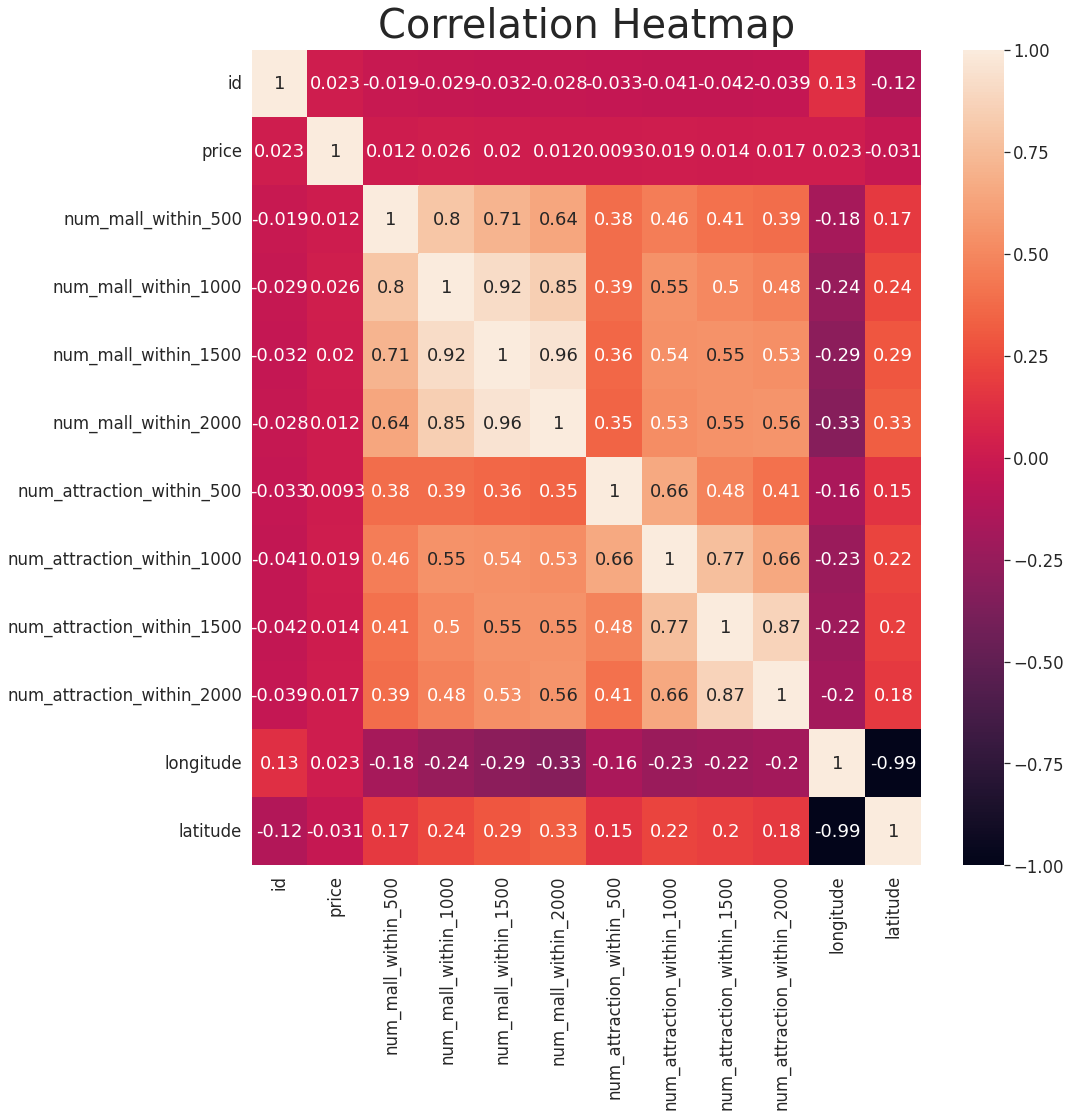

In [38]:
# Investigate which feature to select since most of them are autocorrelated with each other
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(geo_Data.corr(), vmin=-1, vmax=1, annot=True)
title = heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':40}, pad=12)

From the correlation heatmap, we identified that num_mall_within_1000 and num_attraction_within_1000 as the features most correlated (for the num_mall and num_attraction group of features). We then add these features into our dataset, together with the review data.

In [39]:
all_listings_wGeo = pd.merge(all_listings, geo_Data[['id','num_mall_within_1000','num_attraction_within_1000']], on = 'id')
df_median_sentiment.rename(columns={"listing_id": "id"}, inplace = True)
all_listings_final = pd.merge(all_listings_wGeo, df_median_sentiment, on = 'id') # Add sentiment review

In [40]:
train, test = train_test_split(all_listings_final, test_size=0.2, stratify=all_listings_final['state'], random_state = 4222)
train.reset_index(inplace=True)
test.reset_index(inplace=True)

With a total of 75 columns, we determined it is too many for a model. For a first cut, we used our domain knowledge to remove  columns which are not useful for predicting price (e.g. url, host-related features that are unrelated to the property, etc).

We will also drop the columns that:
*   Have a lot of missing values;
*   Seem to be repeated/redundant information (i.e. neighbourhood, neighbourhood_cleansed and neighbourhood_group_cleansed, we can just keep one of them);
*   Will not be used in model selection;
*   Unique identifiers that have no value.



In [41]:
train.columns

Index(['index', 'id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
       'name', 'description', 'neighborhood_overview', 'picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_

In [42]:
### Columns deemed not useful via domain knowledge
toDrop = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 
               'host_url', 'host_thumbnail_url', 'host_picture_url','calendar_updated', 
               'calendar_last_scraped', 'calculated_host_listings_count','calculated_host_listings_count_entire_homes', 
               'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
               'host_since','host_location','host_about','host_neighbourhood','host_listings_count',
               'host_total_listings_count','host_total_listings_count','host_verifications']

There are multiple columns for minimum and maximum night stays which seem to have minimal differences. The default min/max night stay values will be used instead. There are also multiple columns for availability, we use the most recent availability data for each listing, availability_30. The same is the case for number of reviews.

In [43]:
toDrop.append('minimum_minimum_nights')
toDrop.append('maximum_minimum_nights')
toDrop.append('minimum_maximum_nights')
toDrop.append('maximum_maximum_nights')
toDrop.append('minimum_nights_avg_ntm')
toDrop.append('maximum_nights_avg_ntm')
toDrop.append('availability_60')
toDrop.append('availability_90')
toDrop.append('availability_365')
toDrop.append('number_of_reviews_ltm')
toDrop.append('number_of_reviews_l30d')

In [44]:
### Investigate data coverage for each column
pd.set_option('display.max_rows', None)
(train.isna().sum() / train.isna().count()) * 100

index                                             0.000000
id                                                0.000000
listing_url                                       0.000000
scrape_id                                         0.000000
last_scraped                                      0.000000
source                                           17.166381
name                                              0.000000
description                                       1.116066
neighborhood_overview                            28.736421
picture_url                                       0.000000
host_id                                           0.000000
host_url                                          0.000000
host_name                                         0.000000
host_since                                        0.000000
host_location                                    10.920526
host_about                                       33.061178
host_response_time                               14.1040

From here, it seems majority of neighborhood_overview, neighbourhood, neighbourhood_group_cleansed, bathrooms, license are null values.

We determined that out of these features, we will investigate further for license and neighborhood_overview.

In [45]:
pd.set_option('display.max_rows', 10)
train['license'].value_counts()

Exempt                                                                  626
Exempt - This listing is a transient occupancy residential structure    354
License not needed per OSTR                                             249
City registration pending                                               227
Exempt - This listing is a bed and breakfast                            204
                                                                       ... 
HSR20-002789                                                              1
HSR21-000701                                                              1
HSR19-005450                                                              1
HSR22-000548                                                              1
HSR19-003665                                                              1
Name: license, Length: 6261, dtype: int64

Seems like null values in the license column represent a lack of license. In order to represent this information,
we used a boolean to represent the column, filling nulls with 0.

In [46]:
train['has_license'] = train['license'].notnull() * 1
test['has_license'] = test['license'].notnull() * 1
toDrop.append("license")

In [47]:
### To remove other columns
toDrop.append("neighbourhood")
toDrop.append("neighbourhood_group_cleansed")
toDrop.append("bathrooms")

In [48]:
### Explore columns with few unique values that do not contribute to model
# get number of unique values for each column
counts = all_listings.nunique()
counts_dict = counts.to_dict()

# record columns to delete (those that only have 1 or 0 unique values)
to_del = [i for i,v in counts_dict.items() if v == 1 or v == 0]
print(to_del)

# To drop those columns
for i in to_del:
    toDrop.append(i)

['bathrooms', 'calendar_updated']


In [49]:
# Remove all columns to drop now
train.drop(toDrop, axis=1, inplace=True)
test.drop(toDrop, axis=1, inplace=True)

In [50]:
train.head()

,index,id,name,description,neighborhood_overview,host_name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,state,num_mall_within_1000,num_attraction_within_1000,sentiment_median_score,has_license
0,18543,19386625,"Comfortable, Bright and Big Room in South Bay!",Very self sufficient room with extremely comfo...,NaN,Charles,within an hour,100%,93%,t,t,t,Lawndale,33.87593,-118.35802,Private room in home,Private room,1,1 shared bath,1.0,1.0,"[""Clothing storage: closet"", ""Keypad"", ""Toaste...",$53.00,30,95,t,2,29,2017-08-12,2022-04-25,5.00,4.97,4.79,5.00,4.93,4.93,4.90,f,0.47,Los Angeles,0,0,0.93110,0
1,29802,47890807,The Peninsula,"Great location, steps away from the sand and a...",NaN,Devon,within an hour,100%,100%,t,t,t,Long Beach,33.74648,-118.11927,Entire home,Entire home/apt,8,2 baths,3.0,6.0,"[""BBQ grill"", ""Ceiling fan"", ""Bed linens"", ""Ca...",$310.00,2,365,t,0,100,2021-04-11,2022-09-02,4.83,4.86,4.74,4.94,4.95,4.92,4.78,t,5.80,Los Angeles,0,0,0.90870,1
2,8504,51664760,FOUR ROOMS IN A NICE AND QUIET LARGE HOUSE,NaN,NaN,Octavio,within an hour,100%,86%,f,t,f,Sky Line,32.71050,-116.99968,Entire home,Entire home/apt,8,2 baths,4.0,6.0,"[""Dryer"", ""Cooking basics"", ""Keurig coffee mac...",$249.00,1,29,t,23,10,2021-10-03,2022-04-10,4.70,4.80,4.60,4.90,4.80,4.70,4.70,t,0.85,San Diego,0,0,0.65250,0
3,14605,7147061,Lemon Tree Garden Studio,Private Studio | French doors open up to a lem...,"VERY centrally located, family neighborhood, r...",Michael,within an hour,100%,100%,t,t,t,Mid-City,34.03663,-118.35812,Entire guesthouse,Entire home/apt,2,1 bath,1.0,1.0,"[""BBQ grill"", ""Paid washer \u2013 In building""...",$88.00,31,1125,t,2,48,2017-10-13,2022-08-26,4.83,4.90,4.90,5.00,4.98,4.58,4.73,f,0.80,Los Angeles,0,0,0.92835,1
4,36990,14322048,Marriott Newport Coast Villas,Stays are 7 DAYS - FRI to FRI / SAT to SAT / o...,NaN,Hanna,within a few hours,100%,62%,t,t,t,Newport Beach,33.58290,-117.84496,Private room in resort,Private room,8,2 baths,2.0,4.0,"[""Air conditioning"", ""Carbon monoxide alarm"", ...",$500.00,7,1125,t,0,5,2017-07-09,2018-07-28,4.80,4.80,4.20,5.00,4.60,4.80,4.40,f,0.08,Los Angeles,0,0,0.78410,1


In [51]:
pd.set_option('display.max_rows', None)
train.describe()

,index,id,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_30,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,num_mall_within_1000,num_attraction_within_1000,sentiment_median_score,has_license
count,43725.000000,4.372500e+04,43725.000000,43725.000000,43725.000000,39456.000000,43045.000000,43725.000000,43725.000000,43725.000000,43725.000000,43590.000000,43330.000000,43331.000000,43322.000000,43329.000000,43322.000000,43321.000000,43590.000000,43725.000000,43725.000000,43725.000000,43725.000000
mean,27338.832430,3.099449e+07,34.872422,-119.286628,3.983373,1.793846,2.283331,14.036066,616.121761,10.035792,62.503053,4.737501,4.806373,4.744327,4.873250,4.855421,4.821039,4.699569,1.562200,1.106255,0.170063,0.846074,0.229137
std,15792.525769,1.675643e+07,1.860203,2.020856,2.804410,1.143612,1.794454,28.197989,4830.173791,10.569019,92.903383,0.507715,0.341124,0.387602,0.292806,0.322271,0.303169,0.375920,1.831791,3.164477,0.585273,0.167386,0.420282
min,1.000000,1.090000e+02,32.519860,-122.519040,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,-0.996100,0.000000
25%,13678.000000,1.704169e+07,33.759780,-121.991220,2.000000,1.000000,1.000000,2.000000,37.000000,0.000000,7.000000,4.690000,4.760000,4.670000,4.870000,4.850000,4.770000,4.620000,0.270000,0.000000,0.000000,0.831600,0.000000
50%,27388.000000,3.263850e+07,34.071340,-118.355170,3.000000,1.000000,2.000000,3.000000,365.000000,7.000000,26.000000,4.860000,4.900000,4.860000,4.960000,4.950000,4.910000,4.790000,0.860000,0.000000,0.000000,0.891000,0.000000
75%,41029.000000,4.679917e+07,37.342810,-117.919210,6.000000,2.000000,3.000000,30.000000,1125.000000,18.000000,78.000000,4.970000,5.000000,4.970000,5.000000,5.000000,5.000000,4.900000,2.300000,1.000000,0.000000,0.928100,0.000000
max,54656.000000,5.440906e+07,37.896250,-116.896560,16.000000,19.000000,34.000000,1124.000000,999999.000000,30.000000,1702.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,59.890000,32.000000,7.000000,0.998300,1.000000


# Data Exploration

## Textual Fields in Listings

To process the textual fields in the data, we use NLP (TextBlob) in order to obtain the sentiment for each listing. For listings where these fields are null, we set the sentiment for these values to -2, as TextBlob will only return values from -1 to 1 (so we know which are the listings with null values).

In [52]:
def detect_sentiment(text):
  if pd.isnull(text):
    return -2
  blob = TextBlob(str(text))
  return blob.sentiment.polarity

pd.set_option('display.max_rows', 5)
train['description_sentiment'] = train.description.apply(detect_sentiment)
train['neighborhood_overview_sentiment'] = train.neighborhood_overview.apply(detect_sentiment)
train['price'] = train['price'].replace('[\$,]', '', regex=True).astype(float)
train

,index,id,name,description,neighborhood_overview,host_name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,state,num_mall_within_1000,num_attraction_within_1000,sentiment_median_score,has_license,description_sentiment,neighborhood_overview_sentiment
0,18543,19386625,"Comfortable, Bright and Big Room in South Bay!",Very self sufficient room with extremely comfo...,NaN,Charles,within an hour,100%,93%,t,t,t,Lawndale,33.87593,-118.35802,Private room in home,Private room,1,1 shared bath,1.0,1.0,"[""Clothing storage: closet"", ""Keypad"", ""Toaste...",53.0,30,95,t,2,29,2017-08-12,2022-04-25,5.00,4.97,4.79,5.00,4.93,4.93,4.90,f,0.47,Los Angeles,0,0,0.9311,0,0.283363,-2.0
1,29802,47890807,The Peninsula,"Great location, steps away from the sand and a...",NaN,Devon,within an hour,100%,100%,t,t,t,Long Beach,33.74648,-118.11927,Entire home,Entire home/apt,8,2 baths,3.0,6.0,"[""BBQ grill"", ""Ceiling fan"", ""Bed linens"", ""Ca...",310.0,2,365,t,0,100,2021-04-11,2022-09-02,4.83,4.86,4.74,4.94,4.95,4.92,4.78,t,5.80,Los Angeles,0,0,0.9087,1,0.259740,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43723,45822,28989712,SF Luxury living! 8bed/5bath 1 block from subway!,This modern 3000 square foot spacious home boa...,You are conveniently located just ONE BLOCK aw...,Daniel,within an hour,99%,99%,t,t,t,Ocean View,37.70403,-122.46795,Entire home,Entire home/apt,16,5 baths,8.0,16.0,"[""Long term stays allowed"", ""Oven"", ""Free park...",704.0,2,365,t,6,160,2018-10-18,2022-08-19,4.91,4.93,4.88,4.91,4.95,4.84,4.81,f,3.38,San Francisco,2,0,0.8858,0,0.274603,0.0
43724,21235,25839921,Master 1 bedroom condo,Luxury upscale apartment in lovely downtown Lo...,NaN,Quamai,NaN,NaN,NaN,f,t,t,Chinatown,34.06389,-118.24644,Entire condo,Entire home/apt,2,1 bath,1.0,1.0,"[""Hangers"", ""Dryer"", ""Smoke alarm"", ""Kitchen"",...",145.0,30,36,f,0,8,2018-06-25,2019-04-16,4.88,5.00,4.88,4.88,4.88,5.00,4.88,f,0.16,Los Angeles,1,0,0.8726,0,0.114286,-2.0


In [72]:
test['description_sentiment'] = test.description.apply(detect_sentiment)
test['neighborhood_overview_sentiment'] = test.neighborhood_overview.apply(detect_sentiment)
test['price'] = test['price'].replace('[\$,]', '', regex=True).astype(float)

We then plot the distribution of each sample to see how spread out the values are.

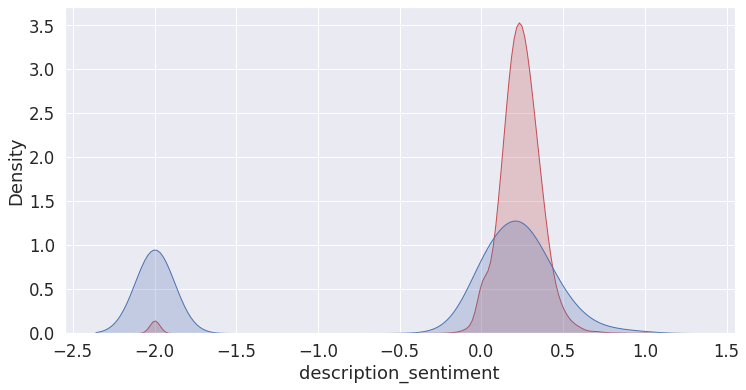

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
fig = sns.kdeplot(train['description_sentiment'], shade=True, color="r")
fig = sns.kdeplot(train['neighborhood_overview_sentiment'], shade=True, color="b")
plt.show()

We see quite a good spread in the data, although description_sentiment is more neutral as compared to neighborhood_overview_sentiment (wider spread for this).

We then bin the sentiments in order to transform them into categorical variables, and encode the missing values as well.

In [54]:
bins = [-2, -1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1.01]
labels = ['NA', 'Very Negative', 'Negative', 'Slightly Negative', 'Neutral', 'Slightly Positive', 'Positive', 'Very Positive']

train['description_sentiment'] = pd.cut(train['description_sentiment'], bins, labels=labels, right=False)
train['neighborhood_overview_sentiment'] = pd.cut(train['neighborhood_overview_sentiment'], bins, labels=labels, right=False)
train

,index,id,name,description,neighborhood_overview,host_name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,state,num_mall_within_1000,num_attraction_within_1000,sentiment_median_score,has_license,description_sentiment,neighborhood_overview_sentiment
0,18543,19386625,"Comfortable, Bright and Big Room in South Bay!",Very self sufficient room with extremely comfo...,NaN,Charles,within an hour,100%,93%,t,t,t,Lawndale,33.87593,-118.35802,Private room in home,Private room,1,1 shared bath,1.0,1.0,"[""Clothing storage: closet"", ""Keypad"", ""Toaste...",53.0,30,95,t,2,29,2017-08-12,2022-04-25,5.00,4.97,4.79,5.00,4.93,4.93,4.90,f,0.47,Los Angeles,0,0,0.9311,0,Slightly Positive,NA
1,29802,47890807,The Peninsula,"Great location, steps away from the sand and a...",NaN,Devon,within an hour,100%,100%,t,t,t,Long Beach,33.74648,-118.11927,Entire home,Entire home/apt,8,2 baths,3.0,6.0,"[""BBQ grill"", ""Ceiling fan"", ""Bed linens"", ""Ca...",310.0,2,365,t,0,100,2021-04-11,2022-09-02,4.83,4.86,4.74,4.94,4.95,4.92,4.78,t,5.80,Los Angeles,0,0,0.9087,1,Slightly Positive,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43723,45822,28989712,SF Luxury living! 8bed/5bath 1 block from subway!,This modern 3000 square foot spacious home boa...,You are conveniently located just ONE BLOCK aw...,Daniel,within an hour,99%,99%,t,t,t,Ocean View,37.70403,-122.46795,Entire home,Entire home/apt,16,5 baths,8.0,16.0,"[""Long term stays allowed"", ""Oven"", ""Free park...",704.0,2,365,t,6,160,2018-10-18,2022-08-19,4.91,4.93,4.88,4.91,4.95,4.84,4.81,f,3.38,San Francisco,2,0,0.8858,0,Slightly Positive,Neutral
43724,21235,25839921,Master 1 bedroom condo,Luxury upscale apartment in lovely downtown Lo...,NaN,Quamai,NaN,NaN,NaN,f,t,t,Chinatown,34.06389,-118.24644,Entire condo,Entire home/apt,2,1 bath,1.0,1.0,"[""Hangers"", ""Dryer"", ""Smoke alarm"", ""Kitchen"",...",145.0,30,36,f,0,8,2018-06-25,2019-04-16,4.88,5.00,4.88,4.88,4.88,5.00,4.88,f,0.16,Los Angeles,1,0,0.8726,0,Neutral,NA


In [ ]:
bins = [-2, -1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1.01]
labels = ['NA', 'Very Negative', 'Negative', 'Slightly Negative', 'Neutral', 'Slightly Positive', 'Positive', 'Very Positive']

test['description_sentiment'] = pd.cut(test['description_sentiment'], bins, labels=labels, right=False)
test['neighborhood_overview_sentiment'] = pd.cut(test['neighborhood_overview_sentiment'], bins, labels=labels, right=False)

In order to find out if there is any correlation between these factors, we plot the distribution split according to the categories.

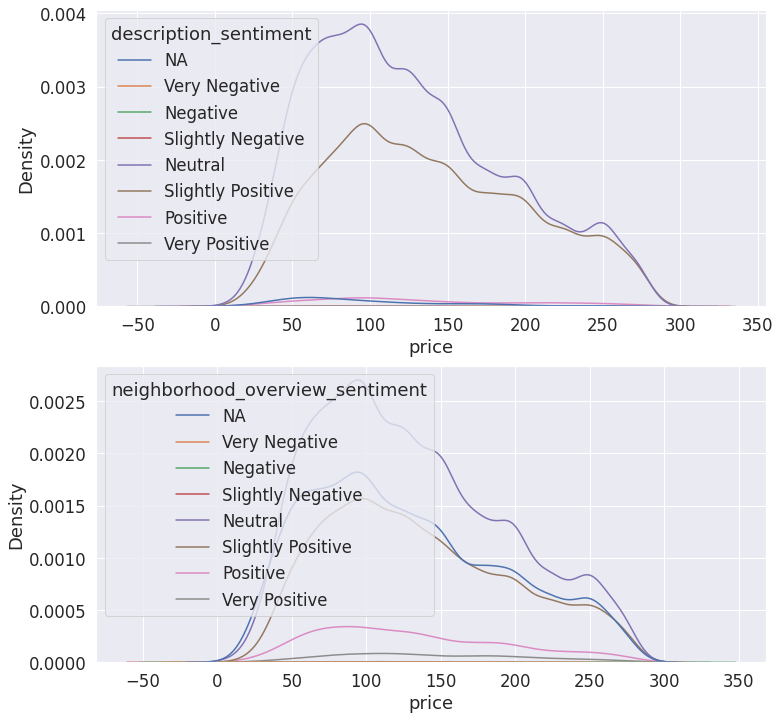

In [55]:
train_filtered = train[train['price'] < 279]

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
plot1 = sns.kdeplot(hue=train_filtered['description_sentiment'], x=train_filtered['price'], ax=ax[0], warn_singular=False)
plot2 = sns.kdeplot(hue=train_filtered['neighborhood_overview_sentiment'], x=train_filtered['price'], ax=ax[1], warn_singular=False)

There is significant overlap between the categories of sentiments - this means that it is not that correlated to the target variable. Regardless, we keep these features as these fields are those that users of Airbnb will inevitably read through will booking listings.

## Price of Listings

We observe the boxplot for price, and see that there is alot of outliers. This implies that we will likely need to perform some form of filtering for the dataset before exporting for model tuning.

Notably, we can see that the 75th percentile of \$279 is much lower than the maximum price, \$100,000.

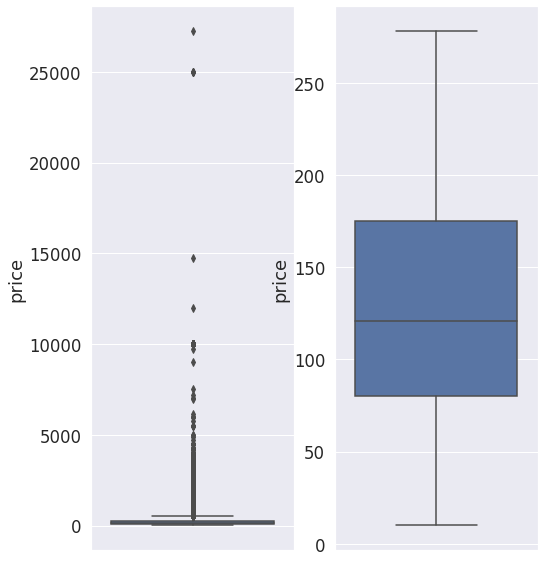

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 10))
sns.boxplot(y=train['price'], ax=ax1)
sns.boxplot(y=train_filtered['price'], ax=ax2)
plt.show()

## Geographical Data of Listings

In order to visualise the geographical spread of listings, we overlay the data samples on a map to get a rough idea of where they are located.

We filter for listings under the 75th percentile, so as to make sure the plot is meaningful (outliers will skew the scale, and the coloring of the data points will be meaningless).

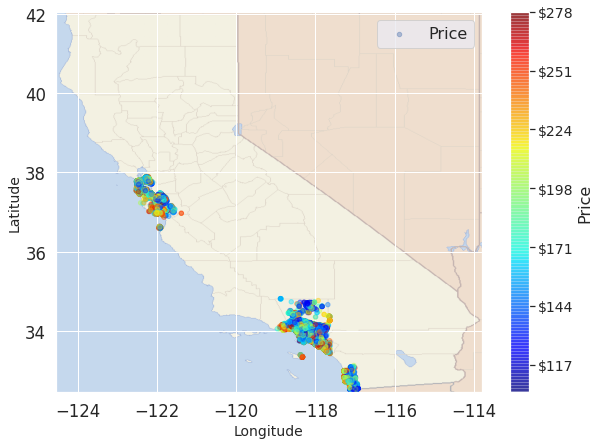

In [57]:
import matplotlib.image as mpimg
california_img = mpimg.imread('/content/drive/My Drive/california.png')
ax = train_filtered.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  label="Price",
                  c="price", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
map = plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
ylabel = plt.ylabel("Latitude", fontsize=14)
xlabel = plt.xlabel("Longitude", fontsize=14)

prices = train_filtered['price']
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
tick_labels = cbar.ax.set_yticklabels(["$%d"%(round(v)) for v in tick_values], fontsize=14)
cbar.set_label('Price', fontsize=16)

legend = plt.legend(fontsize=16)
plt.show()

We also plot the listings against the price, separated by the states they are in. We filter the price, but do not observe any significant relationship between the state variable and the price.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

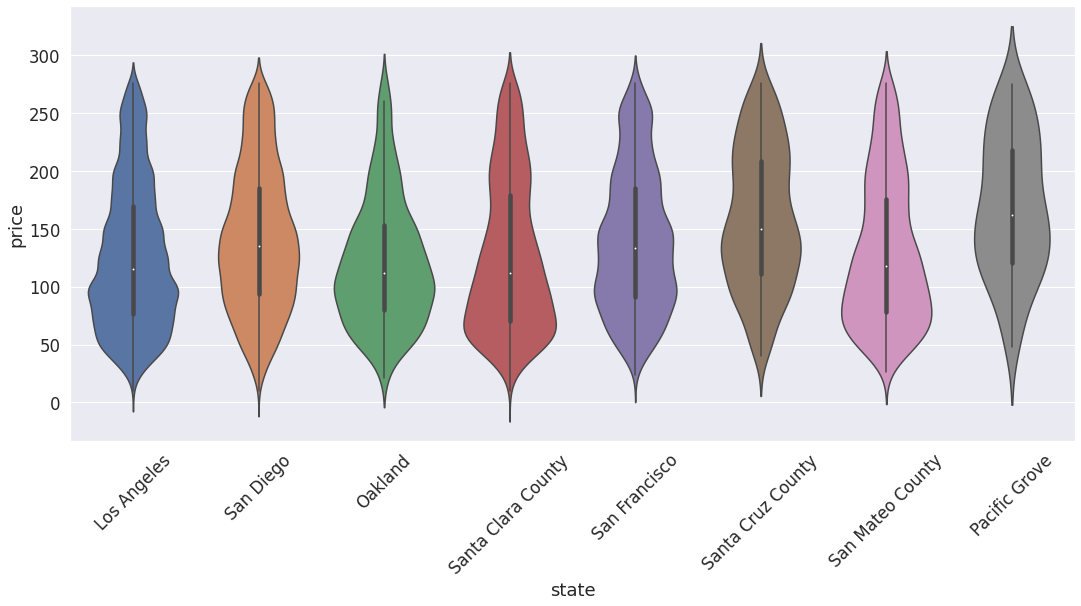

In [58]:
fig, ax = plt.subplots(figsize=(18, 8))
vp = sns.violinplot(data=train[train['price']<277], x='state', y='price')
plt.xticks(rotation=45)

## Property Type

To understand the common types of properties listed for rent on Airbnb, we count the number of listings per distinct property type. 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

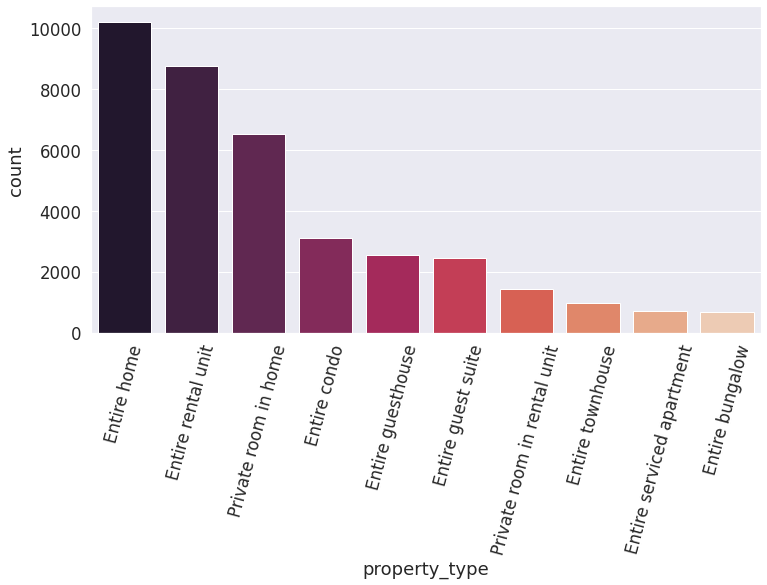

In [59]:
dfg = train.groupby(['property_type']).size().to_frame('count').sort_values('count', ascending = False).head(10).reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
bp = sns.barplot(x=dfg['property_type'], y=dfg['count'], palette='rocket')
plt.xticks(rotation=75)

The most common are hosts that rent out the entire home/unit, with some renting out private rooms. We reason that those who rent out entire homes would charge their guests more.

## Review Scores

With many different metrics for reviews, we want to identify if there is any significant variation/difference between them.

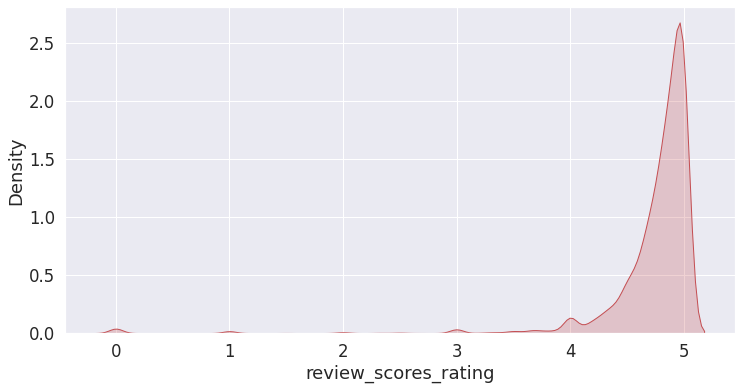

In [60]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(train['review_scores_rating'], shade=True, color='r')

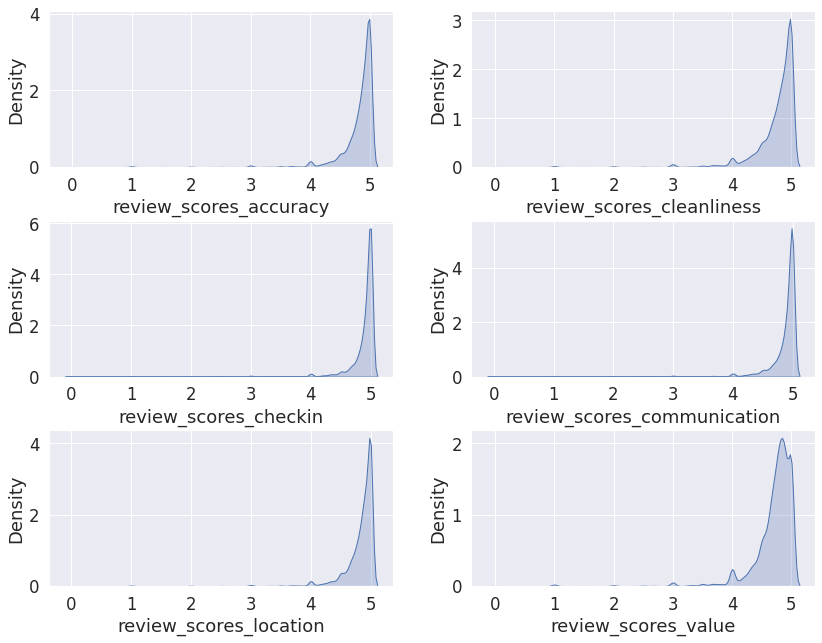

In [61]:
fig, axs = plt.subplots(3, 2, figsize=(12, 9))
fig.tight_layout()
sns.kdeplot(train['review_scores_accuracy'], shade=True, color='b', ax=axs[0,0])
sns.kdeplot(train['review_scores_cleanliness'], shade=True, color='b', ax=axs[0,1])
sns.kdeplot(train['review_scores_checkin'], shade=True, color='b', ax=axs[1,0])
sns.kdeplot(train['review_scores_communication'], shade=True, color='b', ax=axs[1,1])
sns.kdeplot(train['review_scores_location'], shade=True, color='b', ax=axs[2,0])
sns.kdeplot(train['review_scores_value'], shade=True, color='b', ax=axs[2,1])

We see that there is not much difference when it comes to the distributions in the sub-metrics of review scores. Hence, we will most likely keep only one of them for model fitting.

As a last check, we plot the information for the reviews in a correlation plot.

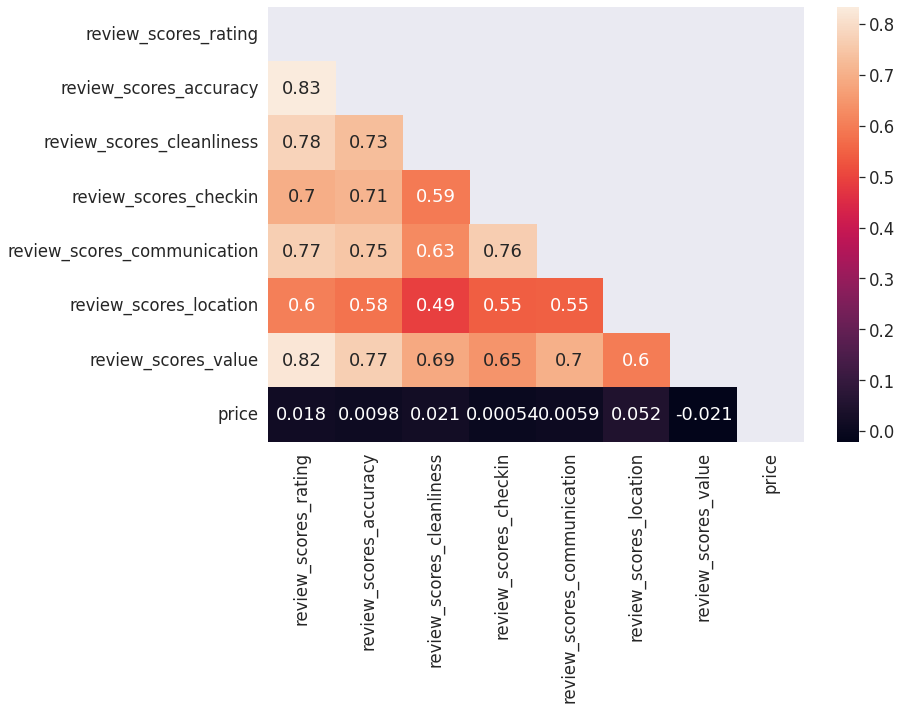

In [62]:
review_and_price = train[['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'price']]
corr = review_and_price.corr()
matrix = np.triu(corr)
fig, ax = plt.subplots(figsize=(12, 8))
heatmap = sns.heatmap(corr, annot=True, mask=matrix)
plt.show()

All of them have a low correlation with price.

## Superhost 

From our own usage of the app, we know that most people filter for superhost when searching for listings. Hence, we also want to investigate if there are any significant differences in the characteristics of superhosts and those who are not superhosts.

([0, 1, 2, 3], <a list of 4 Text major ticklabel objects>)

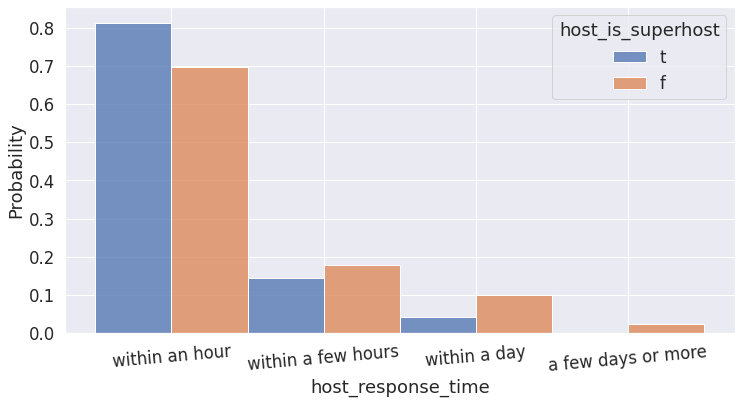

In [63]:
fig, ax = plt.subplots(figsize=(12,6))
hist = sns.histplot(train, x='host_response_time', hue='host_is_superhost', multiple='dodge', stat='probability', common_norm=False)
plt.xticks(rotation=5)

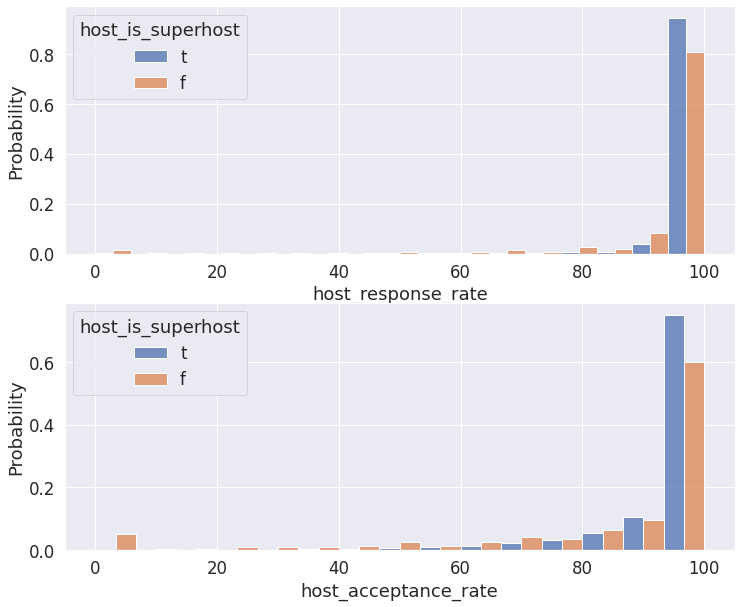

In [64]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
train['host_response_rate'] = train['host_response_rate'].replace('[\%]', '', regex=True).astype(float)
train['host_acceptance_rate'] = train['host_acceptance_rate'].replace('[\%]', '', regex=True).astype(float)
sns.histplot(train, x='host_response_rate', hue='host_is_superhost', multiple='dodge', ax=ax1, stat='probability', common_norm=False)
sns.histplot(train, x='host_acceptance_rate', hue='host_is_superhost', multiple='dodge', ax=ax2, bins=15, stat='probability', common_norm=False)

In [74]:
test['host_response_rate'] = test['host_response_rate'].replace('[\%]', '', regex=True).astype(float)
test['host_acceptance_rate'] = test['host_acceptance_rate'].replace('[\%]', '', regex=True).astype(float)

In [65]:
print("Mean host response rate:", round(train['host_response_rate'].mean(),0))
print("Median host response rate:", train['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((train.host_response_rate == 100.0).sum()/train.host_response_rate.count())*100,1)}%")

Mean host response rate: 97.0
Median host response rate: 100.0
Proportion of 100% host response rates: 78.5%


Generally, superhosts respond to all their potential customers, and at a faster rate. 

## Amenities

Amenities is a feature that contributes to the pricing of the listings, but the format in which this feature is represented in the dataset is not friendly for model training. 

Firstly, the name of each amenity is given by the host, allowing for hosts to include descriptors for each amenity. Hence, there is no standardised amenity naming, and a brief check prior to this showed that there are more than 11,000 distinct amenities in the dataset.

Hence, we would need to process this in such a way that we are able to derive figures that meaningfully represent the number of amenities that each listing has.

Firstly, we try to explore if the raw number of amenities offered by each listing would be a good metric to use.

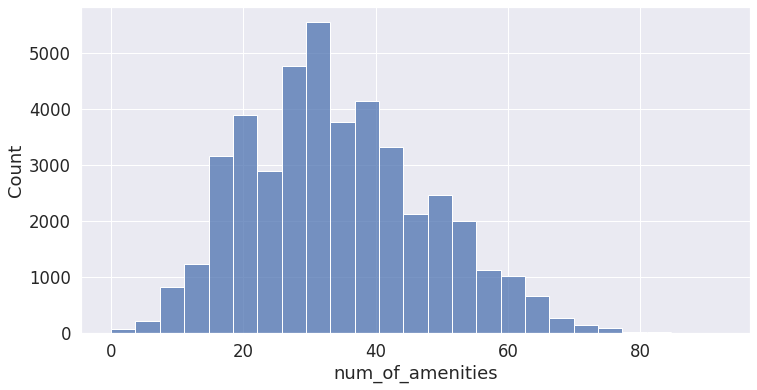

In [66]:
import ast

def get_length(text):
  amenities_list = ast.literal_eval(text)
  return len(amenities_list)

train['num_of_amenities'] = train.amenities.apply(get_length)
fig, ax = plt.subplots(figsize=(12, 6))
hp = sns.histplot(train['num_of_amenities'], bins=25)

In [97]:
test['num_of_amenities'] = test.amenities.apply(get_length)

In [67]:
train['price'].corr(train['num_of_amenities'])

0.10605930988381977

The number of amenities has a low correlation value with the price, we shall try to explore if we can feature engineer this a little more.

We try to map the categories of amenities and count the number of amenities per category for each listing.

In [68]:
import ast

train.reset_index(inplace=True)
amenities_categorisation = {
    'essentials': ['soap', 'shampoo', 'towel', 'conditioner', 'toiletries', 'linen', 'water'],
    'luxury': ['pool', 'tub', 'park', 'sound', 'wifi'],
    'appliances': ['refrigerator', 'stove', 'oven', 'washer', 'dryer', 'microwave'],
    'comfort': ['heat', 'air condition'],
    'entertainment': ['tv', 'console', 'gym', 'game', 'entertainment'],
    'security': ['lock', 'alarm', 'guard'],
    'furniture': ['storage', 'chair', 'table', 'bed']
}

for category in amenities_categorisation.keys():
  train[category] = 0
train['miscellaneous'] = 0

def category_counter(amenity, idx):
  for category, category_list in amenities_categorisation.items():
    for item in category_list:
      if item in amenities.lower():
        train.loc[idx, category] += 1
        return True
  return False

unmapped_amenities = []
for i in range(train.shape[0]):
  amenities_list = ast.literal_eval(train.loc[i, 'amenities'])
  for amenities in amenities_list:
    mapped = category_counter(amenities, i)
    if not mapped:
      train.loc[i, 'miscellaneous'] += 1 
      if amenities not in unmapped_amenities:
        unmapped_amenities.append(amenities)       

In [75]:
test.reset_index(inplace=True)

for category in amenities_categorisation.keys():
  test[category] = 0
test['miscellaneous'] = 0

def category_counter(amenity, idx):
  for category, category_list in amenities_categorisation.items():
    for item in category_list:
      if item in amenities.lower():
        test.loc[idx, category] += 1
        return True
  return False

for i in range(test.shape[0]):
  amenities_list = ast.literal_eval(test.loc[i, 'amenities'])
  for amenities in amenities_list:
    mapped = category_counter(amenities, i)
    if not mapped:
      test.loc[i, 'miscellaneous'] += 1       

In [69]:
len(unmapped_amenities)

178

In [70]:
unmapped_amenities

['Keypad',
 'Toaster',
 'BBQ grill',
 'Dishes and silverware',
 'Shower gel',
 'First aid kit',
 'Essentials',
 'Security cameras on property',
 'Luggage dropoff allowed',
 'Cooking basics',
 'Wine glasses',
 'Coffee maker',
 'Hangers',
 'Mini fridge',
 'Freezer',
 'Backyard',
 'Iron',
 'Kitchen',
 'Long term stays allowed',
 'Cleaning products',
 'Fire extinguisher',
 'Ceiling fan',
 'Outdoor furniture',
 'Private patio or balcony',
 'Private entrance',
 'Keurig coffee machine',
 'Crib',
 'Breakfast',
 'Dedicated workspace',
 'Rice maker',
 'Patio or balcony',
 'Children’s books and toys',
 'Outdoor dining area',
 'Shared fenced garden or backyard',
 'Extra pillows and blankets',
 'Laundromat nearby',
 'AC - split type ductless system',
 'Barbecue utensils',
 'Shared patio or balcony',
 'Baking sheet',
 'Cleaning before checkout',
 'Fire pit',
 'Pack ’n play/Travel crib',
 'Indoor fireplace',
 'Building staff',
 'Window AC unit',
 'Room-darkening shades',
 'Beach essentials',
 'Drying

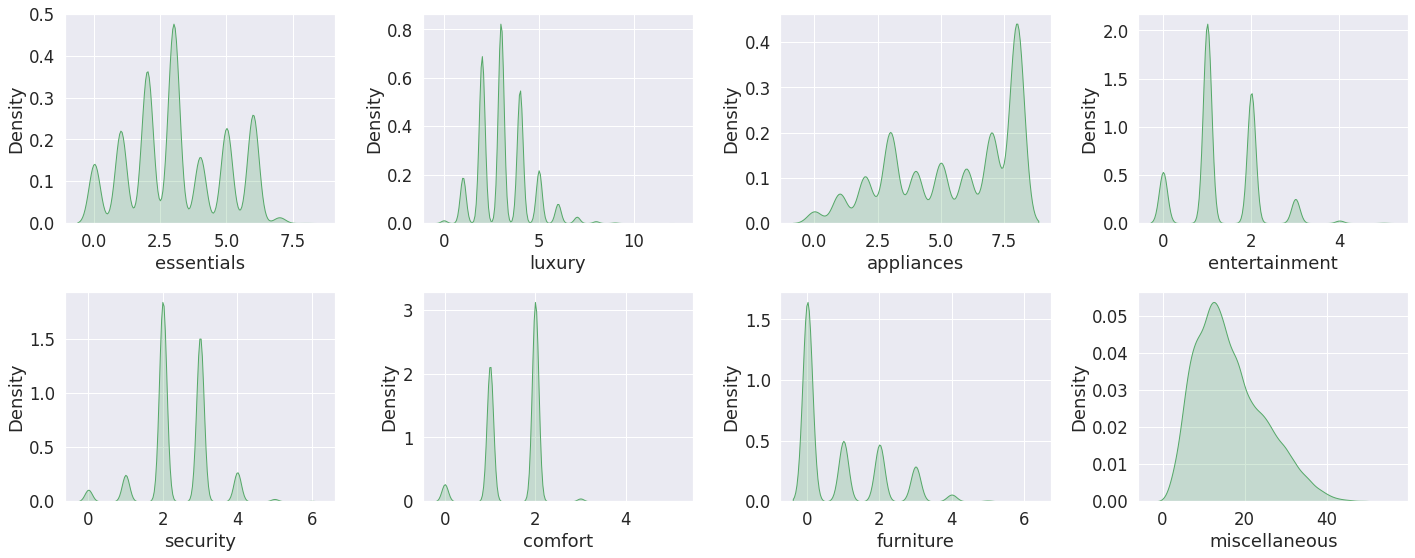

In [71]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
fig = sns.kdeplot(train['essentials'], shade=True, color="g", ax=ax[0,0])
fig = sns.kdeplot(train['luxury'], shade=True, color="g", ax=ax[0,1])
fig = sns.kdeplot(train['appliances'], shade=True, color="g", ax=ax[0,2])
fig = sns.kdeplot(train['entertainment'], shade=True, color="g", ax=ax[0,3])
fig = sns.kdeplot(train['security'], shade=True, color="g", ax=ax[1,0])
fig = sns.kdeplot(train['comfort'], shade=True, color="g", ax=ax[1,1])
fig = sns.kdeplot(train['furniture'], shade=True, color="g", ax=ax[1,2])
fig = sns.kdeplot(train['miscellaneous'], shade=True, color="g", ax=ax[1,3])
plt.tight_layout()
plt.show()

It seems like we managed to map most of the amenities, from over 11,000 distinct amenities to 178 unmapped. The distributions for each category of amenity also seems to show relatively good spread, hence we shall try to use these in model training.

## Host Gender

We also create a feature for the gender of the host as we want to investigate if this plays a part in the pricing of the listing.

In [76]:
!pip install gender_guesser
import gender_guesser.detector as gender

d = gender.Detector()
train['host_gender'] = train['host_name'].apply(lambda x: d.get_gender(x))

gender_mapping = {'mostly_female': 'female', 'mostly_male': 'male', 'andy': 'unknown'}

train = train.replace({'host_gender': gender_mapping})

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 379 kB 5.1 MB/s 


In [77]:
test['host_gender'] = test['host_name'].apply(lambda x: d.get_gender(x))
test = test.replace({'host_gender': gender_mapping})

# Formatting Data

In [79]:
pd.set_option('display.max_rows', None)
train.isnull().sum()

level_0                                0
index                                  0
id                                     0
name                                   0
description                          488
neighborhood_overview              12565
host_name                              0
host_response_time                  6167
host_response_rate                  6167
host_acceptance_rate                4607
host_is_superhost                      0
host_has_profile_pic                   0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          0
room_type                              0
accommodates                           0
bathrooms_text                        21
bedrooms                            4269
beds                                 680
amenities                              0
price                                  0
minimum_nights  

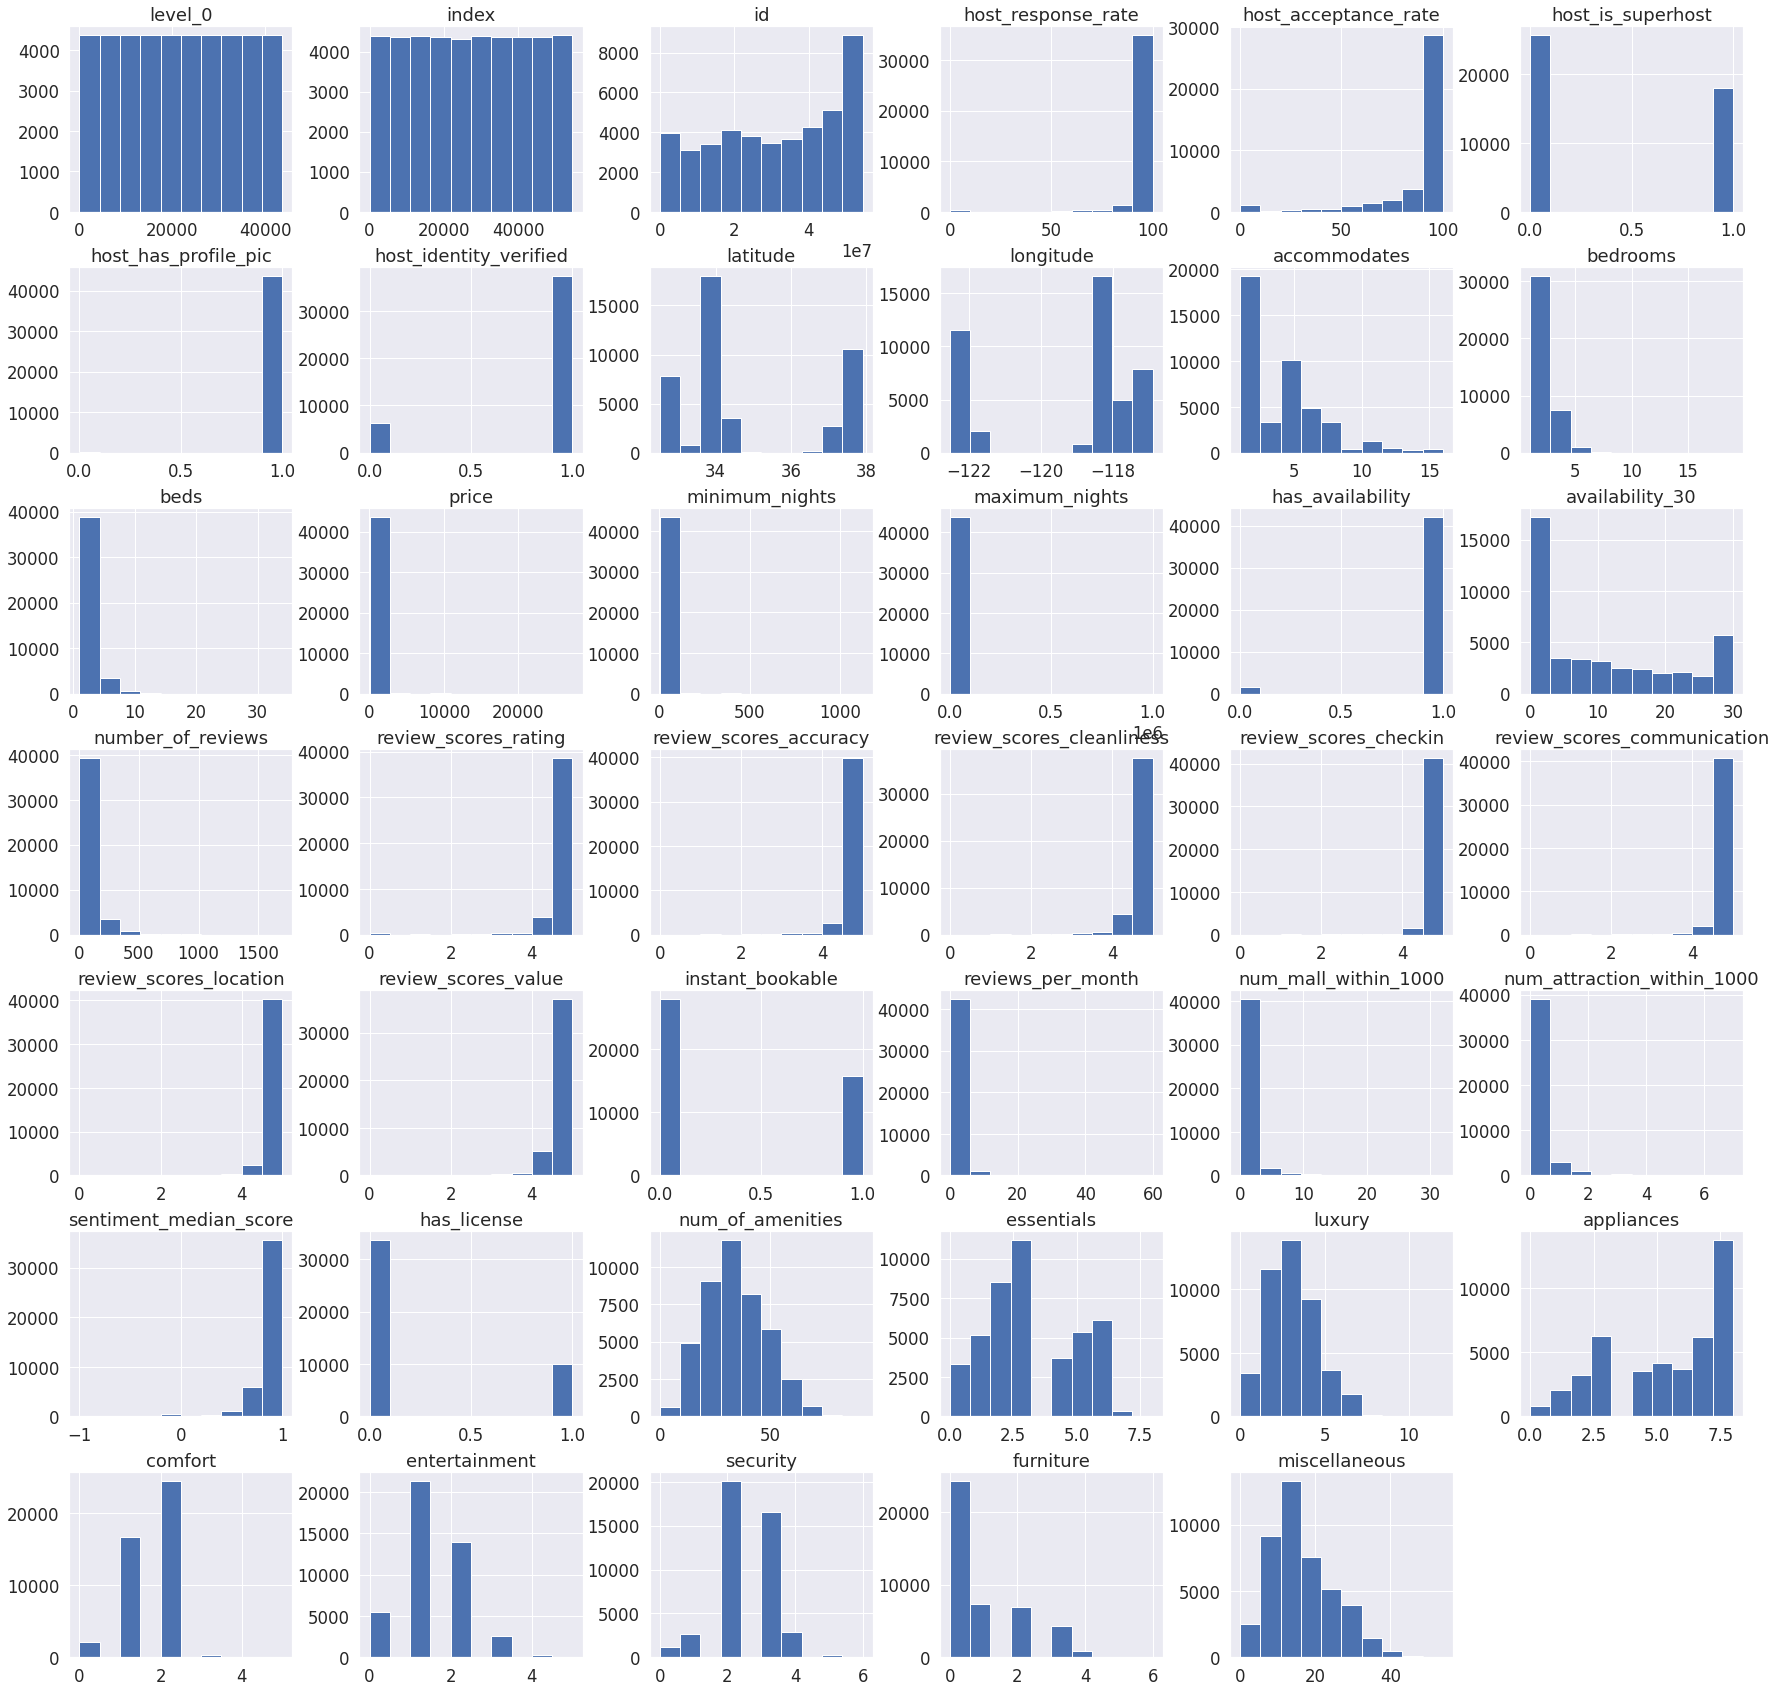

In [80]:
# Replacing columns with f/t with 0/1
train.replace({'f': 0, 't': 1}, inplace=True)
test.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
histplot = train.hist(figsize=(30,30))

In [81]:
# Drop those that have generally fall into one category. We also add columns we mentioned that we do not need earlier.
new_toDrop = ['has_availability', 'host_has_profile_pic', 'description', 'neighborhood_overview', 'review_scores_accuracy', 
              'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
              'review_scores_value', 'level_0', 'index', 'id', 'num_of_amenities']

From the above, we can see that listing names do not have much sentiment enclosed in them, so we shall not use them in our model training as well.

In [82]:
new_toDrop.append('name')

We bin review_scores_rating, and fill null values with NA.

In [83]:
review_bins = []
review_bin_labels = []

left, right = 0, 0.1
for i in range(50):
  review_bins += [left]
  label = str(left) + ' to ' + str(right)
  review_bin_labels += [label]
  left = round(left + 0.1, 1)
  right = round(right + 0.1, 1)
  if i == 49:
    review_bins += [5.1]

train['review_scores_rating'] = pd.cut(train['review_scores_rating'], bins=review_bins, labels=review_bin_labels, right=False)

train['reviews_per_month'] = train['reviews_per_month'].fillna(value=0)

cat_dtype = CategoricalDtype(categories=review_bin_labels+['NA'])
train['review_scores_rating'] = train['review_scores_rating'].astype(cat_dtype)
train['review_scores_rating'] = train['review_scores_rating'].fillna(value='NA')

train.first_review = train.first_review.astype('category')
train.last_review = train.last_review.astype('category')

In [86]:
test['review_scores_rating'] = pd.cut(test['review_scores_rating'], bins=review_bins, labels=review_bin_labels, right=False)

test['reviews_per_month'] = test['reviews_per_month'].fillna(value=0)

cat_dtype = CategoricalDtype(categories=review_bin_labels+['NA'])
test['review_scores_rating'] = test['review_scores_rating'].astype(cat_dtype)
test['review_scores_rating'] = test['review_scores_rating'].fillna(value='NA')

test.first_review = test.first_review.astype('category')
test.last_review = test.last_review.astype('category')

We also want to investigate the missing superhost data. Instead of dropping them directly first, we see if the data points with no superhost data follows the distribution of those who aren't superhost. If they are, we can fill the missing values with 0.

In [84]:
superhost_missing = train[train['host_is_superhost'].isna()]
price_info = pd.DataFrame(columns = ['superhost_missing', 'train', 'not_superhost'])
price_info['superhost_missing'] = superhost_missing['price'].describe()
price_info['train'] = train['price'].describe()
price_info['not_superhost'] = train[train['host_is_superhost'] == 0]['price'].describe()
price_info

,superhost_missing,train,not_superhost
count,0.0,43725.000000,25695.000000
mean,NaN,251.428346,262.450316
std,NaN,552.481251,674.578092
min,NaN,10.000000,10.000000
25%,NaN,93.000000,88.000000
50%,NaN,150.000000,145.000000
75%,NaN,263.000000,256.000000
max,NaN,27238.000000,27238.000000


The distribution is not similar, hence these values are also outliers. We drop those rows with null values for host_is_superhost.

In [87]:
train = train[train['host_is_superhost'].notna()]
test = test[test['host_is_superhost'].notna()]

For response and acceptance rate, we bin them, and fill those null values with NA.

In [88]:
bins = [0, 50, 70, 80, 90, 95, 101]
response_rate_labels = ['unresponsive', 'somewhat unresponsive', 'somewhat responsive', 'responsive', 'very responsive', 'extremely responsive']
acceptance_rate_labels = ['very low', 'low', 'average', 'high', 'very high', 'extremely high']
train['host_response_rate'] = pd.cut(train['host_response_rate'], bins=bins, labels=response_rate_labels, right=False)
train['host_acceptance_rate'] = pd.cut(train['host_acceptance_rate'], bins=bins, labels=acceptance_rate_labels, right=False)

cat_dtype_response = CategoricalDtype(categories=response_rate_labels+['NA'])
cat_dtype_acceptance = CategoricalDtype(categories=acceptance_rate_labels+['NA'])
train['host_response_rate'] = train['host_response_rate'].astype(cat_dtype_response)
train['host_acceptance_rate'] = train['host_acceptance_rate'].astype(cat_dtype_acceptance)
train['host_response_rate'] = train['host_response_rate'].fillna('NA')
train['host_acceptance_rate'] = train['host_acceptance_rate'].fillna('NA')

In [89]:
test['host_response_rate'] = pd.cut(test['host_response_rate'], bins=bins, labels=response_rate_labels, right=False)
test['host_acceptance_rate'] = pd.cut(test['host_acceptance_rate'], bins=bins, labels=acceptance_rate_labels, right=False)

cat_dtype_response = CategoricalDtype(categories=response_rate_labels+['NA'])
cat_dtype_acceptance = CategoricalDtype(categories=acceptance_rate_labels+['NA'])
test['host_response_rate'] = test['host_response_rate'].astype(cat_dtype_response)
test['host_acceptance_rate'] = test['host_acceptance_rate'].astype(cat_dtype_acceptance)
test['host_response_rate'] = test['host_response_rate'].fillna('NA')
test['host_acceptance_rate'] = test['host_acceptance_rate'].fillna('NA')

In [90]:
### Check host response time
print("Null values:", train.host_response_time.isna().sum())
print(f"Proportion: {round((train.host_response_time.isna().sum()/len(train))*100, 1)}%")

train[['first_review', 'last_review']].isnull().sum()

Null values: 6167
Proportion: 14.1%


first_review    135
last_review     135
dtype: int64

Since there are many null values for first and last review, we drop them (from our reasoning, these features are also less commonly used by users of Airbnb).

In [91]:
new_toDrop.append('first_review')
new_toDrop.append('last_review')

In [92]:
# Property Types
train.property_type.value_counts()

Entire home                           10201
Entire rental unit                     8751
Private room in home                   6505
Entire condo                           3114
Entire guesthouse                      2545
Entire guest suite                     2441
Private room in rental unit            1439
Entire townhouse                        971
Entire serviced apartment               693
Entire bungalow                         667
Private room in condo                   634
Room in boutique hotel                  573
Private room in townhouse               535
Entire cottage                          514
Private room in guest suite             465
Entire loft                             446
Entire villa                            401
Room in hotel                           306
Shared room in home                     305
Private room in villa                   234
Private room in bungalow                191
Private room in guesthouse              166
Tiny home                       

In [93]:
train.room_type.value_counts()

Entire home/apt    31504
Private room       11512
Shared room          547
Hotel room           162
Name: room_type, dtype: int64

There's a lot of categories here which may not be useful to the model. On the other hand, room_type provides a good summary of the types of listings. Hence, we shall choose to use room_type instead of property_type.

In [94]:
new_toDrop.append('property_type')

In [95]:
train['host_response_time'].value_counts()
train['host_response_time'] = train['host_response_time'].fillna('NA')

within an hour        28223
within a few hours     6085
within a day           2734
a few days or more      516
Name: host_response_time, dtype: int64

host_response_time is a categorical variable, so we shall fill the null values with NA.

In [98]:
train.drop(new_toDrop, axis=1, inplace=True)
test.drop(new_toDrop, axis=1, inplace=True)

In [99]:
train.isnull().sum()

host_name                             0
host_response_time                    0
host_response_rate                    0
host_acceptance_rate                  0
host_is_superhost                     0
host_identity_verified                0
neighbourhood_cleansed                0
latitude                              0
longitude                             0
room_type                             0
accommodates                          0
bathrooms_text                       21
bedrooms                           4269
beds                                680
amenities                             0
price                                 0
minimum_nights                        0
maximum_nights                        0
availability_30                       0
number_of_reviews                     0
review_scores_rating                  0
instant_bookable                      0
reviews_per_month                     0
state                                 0
num_mall_within_1000                  0


For bathroom information, we split into the quantity and type, and encode the missing values accordingly.

In [100]:
train["bathrooms"] = train["bathrooms_text"].str.split(" ", expand=True)[0]
train["bathroom_type"] = train["bathrooms_text"].str.split(" ", expand=True)[1]
train.drop("bathrooms_text", axis = 1, inplace= True)

test["bathrooms"] = test["bathrooms_text"].str.split(" ", expand=True)[0]
test["bathroom_type"] = test["bathrooms_text"].str.split(" ", expand=True)[1]
test.drop("bathrooms_text", axis = 1, inplace= True)

In [101]:
train['bathrooms'] = train['bathrooms'].fillna('NA')
train['bathroom_type'] = train['bathroom_type'].fillna('NA')

test['bathrooms'] = test['bathrooms'].fillna('NA')
test['bathroom_type'] = test['bathroom_type'].fillna('NA')

In [102]:
# Bathrooms should ideally be a count
mapping = {'Private': '1', 'Shared': '1', 'Half-bath': '1', 'NA': '1'}

train = train.replace({'bathrooms': mapping})
train['bathrooms'] = train['bathrooms'].astype('str').astype('float')

test = test.replace({'bathrooms': mapping})
test['bathrooms'] = test['bathrooms'].astype('str').astype('float')

We only have bedrooms and beds left to fill in null values for. We shall use linear regression to approximate the number of bedrooms and beds based on the number of people the listing accommodates.

In [104]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

bedroom_not_na = train[train['bedrooms'].notna()]
bedrooms = bedroom_not_na['bedrooms']
accommodates = bedroom_not_na[['accommodates']]
bedrooms_model = LinearRegression()
bedrooms_model.fit(accommodates, bedrooms)
bedroom_pred = bedrooms_model.predict(accommodates)
mean_squared_error(bedrooms, bedroom_pred)

LinearRegression()

0.33908118600911313

In [105]:
bed_not_na = train[train['beds'].notna()]
beds = bed_not_na['beds']
accommodates = bed_not_na[['accommodates']]
beds_model = LinearRegression()
beds_model.fit(accommodates, beds)
bedroom_pred = beds_model.predict(accommodates)
mean_squared_error(beds, bedroom_pred)

LinearRegression()

0.8315895057002259

In [106]:
import math
import warnings

warnings.simplefilter("ignore", UserWarning)
for index, row in train.iterrows():
  value = row['accommodates']
  if math.isnan(row['bedrooms']):
    train.at[index, 'bedrooms'] = round(bedrooms_model.predict([[value]])[0])
  if math.isnan(row['beds']):
    train.at[index, 'beds'] = round(beds_model.predict([[value]])[0])

In [107]:
for index, row in test.iterrows():
  value = row['accommodates']
  if math.isnan(row['bedrooms']):
    test.at[index, 'bedrooms'] = round(bedrooms_model.predict([[value]])[0])
  if math.isnan(row['beds']):
    test.at[index, 'beds'] = round(beds_model.predict([[value]])[0])

In [109]:
train.dtypes

host_name                            object
host_response_time                   object
host_response_rate                 category
host_acceptance_rate               category
host_is_superhost                     int64
host_identity_verified                int64
neighbourhood_cleansed               object
latitude                            float64
longitude                           float64
room_type                            object
accommodates                          int64
bedrooms                            float64
beds                                float64
amenities                            object
price                               float64
minimum_nights                        int64
maximum_nights                        int64
availability_30                       int64
number_of_reviews                     int64
review_scores_rating               category
instant_bookable                      int64
reviews_per_month                   float64
state                           

We don't need latitude and longitude, since we have the geospatial data, and we don't need host_name and amenities either. Neighbourhood_cleansed has too many categories, so we drop it as well.

In [110]:
train.drop(['latitude', 'longitude', 'host_name', 'amenities', 'neighbourhood_cleansed'], axis=1, inplace=True)
test.drop(['latitude', 'longitude', 'host_name', 'amenities', 'neighbourhood_cleansed'], axis=1, inplace=True)

# Export Data

In [111]:
val, test = train_test_split(test, train_size=0.5, random_state=4222)
train.to_csv('/content/drive/My Drive/BT4222 Data Mining/Code & Data/train.csv')
val.to_csv('/content/drive/My Drive/BT4222 Data Mining/Code & Data/val.csv')
test.to_csv('/content/drive/My Drive/BT4222 Data Mining/Code & Data/test.csv')